# Data Processing

In [7]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
from sklearn.ensemble import GradientBoostingRegressor
import sys
import matplotlib.pyplot as plt
%matplotlib notebook

def get_all_data(prefix, loc_lat, loc_lon, sy, ey):
	def search_index(array, value):
		if value < array[0]:
			return 0
		for i in range(0, len(array)-1):
			if array[i] <= value and value < array[i+1]:
				return i
		return i

	def split(arr, size):
		arrs = []
		while len(arr) > size:
			pice = arr[:size]
			arrs.append(pice)
			arr = arr[size:]
			arrs.append(arr)
		return arrs

	def get_data(path, loc_lat, loc_lon):
		dataset = Dataset(path)
		lon = dataset.variables['lon'][:]
		lat = dataset.variables['lat'][:]
		lat_index = search_index(lat, loc_lat)
		lon_index = search_index(lon, loc_lon)
		t = dataset.variables["pr"][:,lat_index, lon_index].tolist();
		t = [3600*x for x in t]
		return split(t, 365)

	res = []
	for i in ["20060101-20401231", "20410101-20751231", "20760101-21001231"]:
		fn = prefix+"/"+"pr_day_CCSM4_rcp85_r1i1p1_"+i+".nc"
		res = res + get_data(fn, loc_lat, loc_lon)
	return res[sy-2006:ey-2006]

def get_monthly_acc(filename):
	data = pd.read_csv(filename, header=0,low_memory=False)
	data['ymstr'] = data.Date.copy().str.slice(6, 10)+data.Date.copy().str.slice(3, 5)
	dic = data['ymstr'].value_counts().to_dict()
	x=list(dic.keys())
	x.sort()
	res=[]
	for i in x:
		res.append(dic[i])
	return res[12:]

def split_to_month(l):
	days_in_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
	res = []
	start = 0
	end = 0
	for i in range(0, 12):
		start += days_in_month[i]
		end += days_in_month[i+1]
		res.append(l[start:end])
	return res


def get_top_prep(prefix, start, end, n_features):
	loc_lat = 51.513917
	loc_lon = 360-0.172638
	a = get_all_data(prefix, loc_lat, loc_lon, start, end)

	month_prep = []
	for y in a:
		month_prep += split_to_month(y)

	month_top_prep = []
	for m in month_prep:
		month_top_prep.append(sorted(m,reverse=True)[:n_features])	
	return month_top_prep

y = np.array(get_monthly_acc('Accidents0515.csv'))
X = np.array(get_top_prep('/Users/hhu/Downloads/data/', 2006, 2016, 5))

# Gradient Boosting Tree Modeling

In [ ]:
gbm = GradientBoostingRegressor(learning_rate = 0.1, random_state = 1234)
m = gbm.fit(X, y)
score = m.score(X,y)

# Plotting the 2nd plot

In [11]:
X_pred = np.array(get_top_prep('/Users/hhu/Downloads/data/', 2020, 2100, 5))
y_pred = gbm.predict(X_pred)
yearly = y_pred.reshape(int(len(y_pred)/12), 12)
yearly_sum = [sum(i) for i in yearly]

<IPython.core.display.Javascript object>


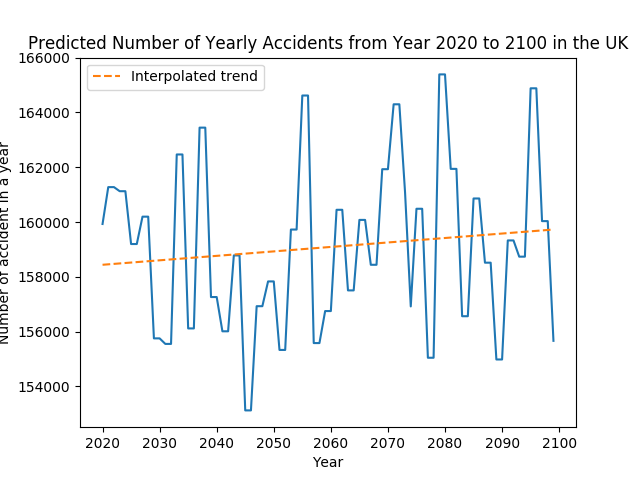

Text(0.5,1,'Predicted Number of Yearly Accidents from Year 2020 to 2100 in the UK')

In [25]:
plt.plot(range(2020, 2100), yearly_sum)
plt.xlabel('Year')
plt.ylabel('Number of accident in a year')

from scipy import stats
xi = range(2020, 2100)
y = yearly_sum
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept
plt.plot(xi,line,'--',label='Interpolated trend')
plt.legend()
plt.title('Predicted Number of Yearly Accidents from Year 2020 to 2100 in the UK')